In [1]:
import findspark
findspark.init()

import os
print(os.getcwd())

from platform import python_version
print(python_version())

C:\Users\frank\Documents\Programming\GitRepos\pyspark-bank-term-deposit-subscription\Code
3.9.13


In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Users\frank\apps\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
sc.uiWebUrl

'http://host.docker.internal:4040'

In [5]:
from pyspark.sql.functions import col, isnan, when, count, countDistinct, udf
from pyspark.sql import functions
from pyspark.ml.functions import array_to_vector
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import math

# Load Data as Correct Data Types

In [6]:
schema = StructType([
    StructField("Age", IntegerType()),
    StructField("Job", StringType()),
    StructField("Marital", StringType()),
    StructField("Education", StringType()),
    StructField("Default", StringType()),
    StructField("Housing", StringType()),
    StructField("Loan", StringType()),
    StructField("Contact", StringType()),
    StructField("Month", StringType()),
    StructField("Day_of_week", StringType()),
    StructField("Duration", IntegerType()),
    StructField("Campaign", IntegerType()),
    StructField("Pdays", IntegerType()),
    StructField("Previous", IntegerType()),
    StructField("Poutcome", StringType()),
    StructField("Emp_var_rate", DoubleType()),
    StructField("Cons_price_idx", DoubleType()),
    StructField("Cons_conf_idx", DoubleType()),
    StructField("Euribor3m", DoubleType()),
    StructField("Nr_employed", DoubleType()),
    StructField("y", StringType())
])
 
df = spark.read.csv("XYZ_Bank_Deposit_Data_Classification.csv", header=True, schema=schema, sep=";")
df.show(3)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|Age|      Job|Marital|  Education|Default|Housing|Loan|  Contact|Month|Day_of_week|Duration|Campaign|Pdays|Previous|   Poutcome|Emp_var_rate|Cons_price_idx|Cons_conf_idx|Euribor3m|Nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [7]:
df.dtypes

[('Age', 'int'),
 ('Job', 'string'),
 ('Marital', 'string'),
 ('Education', 'string'),
 ('Default', 'string'),
 ('Housing', 'string'),
 ('Loan', 'string'),
 ('Contact', 'string'),
 ('Month', 'string'),
 ('Day_of_week', 'string'),
 ('Duration', 'int'),
 ('Campaign', 'int'),
 ('Pdays', 'int'),
 ('Previous', 'int'),
 ('Poutcome', 'string'),
 ('Emp_var_rate', 'double'),
 ('Cons_price_idx', 'double'),
 ('Cons_conf_idx', 'double'),
 ('Euribor3m', 'double'),
 ('Nr_employed', 'double'),
 ('y', 'string')]

# Check for Nulls

In [8]:
df.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|Age|Job|Marital|Education|Default|Housing|Loan|Contact|Month|Day_of_week|Duration|Campaign|Pdays|Previous|Poutcome|Emp_var_rate|Cons_price_idx|Cons_conf_idx|Euribor3m|Nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



# Helper Fuctions

In [9]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Transformations

In [10]:
# create a copy of the dataset
df2 = df.alias('df2')

### Label Indexing

In [11]:
# string indexer (label encoding) for categorical columns - Job, Education, Contact, Month
for col in ['Job', 'Education', 'Contact', 'Housing', 'Loan', 'Marital', 'Default', 'Poutcome']:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    df2 = indexer.fit(df2).transform(df2)

# one hot encoder for the following categorical columns - Housing, Loan, Marital, Default, Poutcome
for col in ['Housing', 'Loan', 'Marital', 'Default', 'Poutcome']:
    encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec")
    df2 = encoder.fit(df2).transform(df2)

### Numeric Encoding in Order

In [12]:
# month
# helper function for converting month to numbers
def helper_function_month(month):
      if (month == 'jan'):
        return 1
      elif (month == 'feb'):
        return 2
      elif (month == 'mar'):
        return 3
      elif (month == 'apr'):
        return 4
      elif (month == 'may'):
        return 5
      elif (month == 'jun'):
        return 6
      elif (month == 'jul'):
        return 7
      elif (month == 'aug'):
        return 8
      elif (month == 'sep'):
        return 9
      elif (month == 'oct'):
        return 10
      elif (month == 'nov'):
        return 11
      elif (month == 'dec'):
        return 12
      else: 
        return 0
      
# day of the week
# helper function for converting day of week to numbers
def helper_function_day_of_week(day_of_week):
      if (day_of_week == 'mon'):
        return 1
      elif (day_of_week == 'tue'):
        return 2
      elif (day_of_week == 'wed'):
        return 3
      elif (day_of_week == 'thu'):
        return 4
      elif (day_of_week == 'fri'):
        return 5
      else: 
        return 0
      
# target variable
# helper function for y target variable No = 0, Yes = 1
def helper_function_y(y):
      if (y == 'no'):
        return 0
      elif (y == 'yes'):
        return 1
      else: 
        return 0


udf_month = udf(helper_function_month, IntegerType())
df2 = df2.withColumn("Month_index", udf_month('Month'))

udf_day_of_week = udf(helper_function_day_of_week, IntegerType())
df2 = df2.withColumn("Day_of_week_index", udf_day_of_week('Day_of_week'))

udf_y = udf(helper_function_y, IntegerType())
df2 = df2.withColumn("label", udf_y('y'))

### Log Transformation and Binary Encoding

In [13]:
# log transformation of Campaign + 0.01
log_transform_udf = udf(lambda x: math.log(x + 0.01), DoubleType())
df2 = df2.withColumn("Campaign_log", log_transform_udf("Campaign"))

# log transformation of Duration + 0.01
df2 = df2.withColumn("Duration_log", log_transform_udf("Duration"))

#pdays binned binary >=999 then 0 else 1
udf_pdays = udf(lambda y: 0 if y >= 999 else 1, IntegerType())
df2 = df2.withColumn("Pdays_binary_flag", udf_pdays('Pdays'))

In [14]:
df2.show(3)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+---------+---------------+-------------+-------------+----------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+-----------+-----------------+-----+--------------------+-----------------+-----------------+
|Age|      Job|Marital|  Education|Default|Housing|Loan|  Contact|Month|Day_of_week|Duration|Campaign|Pdays|Previous|   Poutcome|Emp_var_rate|Cons_price_idx|Cons_conf_idx|Euribor3m|Nr_employed|  y|Job_index|Education_index|Contact_index|Housing_index|Loan_index|Marital_index|Default_index|Poutcome_index|  Housing_vec|     Loan_vec|  Marital_vec|  Default_vec| Poutcome_vec|Month_index|Day_of_week_index|label|        Campaign_log|     Duration_log|Pdays_binary_flag|
+---+---------+-------+-----------+-------+-------+----+------

### One hot encoding, standardization, train-test split

In [15]:
########################################## with one hot encoding ##########################################
inputCols = ['Age', 'Job_index', 'Education_index', 'Contact_index', 'Month_index', 'Day_of_week_index', 'Duration_log', 
             'Campaign_log', 'Pdays', 'Pdays_binary_flag', 'Previous', 'Emp_var_rate', 'Cons_price_idx', 'Cons_conf_idx', 'Euribor3m', 'Nr_employed', 
             'Housing_vec', 'Loan_vec', 'Marital_vec', 'Default_vec', 'Poutcome_vec']

# vector assembler
df2_assembler = VectorAssembler(inputCols=inputCols, outputCol="features_vectorized")
df2 = df2_assembler.transform(df2)

# standard scaler
scaler = StandardScaler(inputCol="features_vectorized", outputCol="features", withStd=True, withMean=False)
scalerModel = scaler.fit(df2)
df2 = scalerModel.transform(df2)

# split the data into train and test
train, test = df2.randomSplit([0.7, 0.3], seed=12345)


########################################## without one hot encoding ##########################################

inputColsNotEncoded = ['Age', 'Job_index', 'Education_index', 'Contact_index', 'Month_index', 'Day_of_week_index', 'Duration_log', 
             'Campaign_log', 'Pdays', 'Pdays_binary_flag', 'Previous', 'Emp_var_rate', 'Cons_price_idx', 'Cons_conf_idx', 'Euribor3m', 'Nr_employed', 
             'Housing_index', 'Loan_index', 'Marital_index', 'Default_index', 'Poutcome_index']

# vector assembler
df3_assembler = VectorAssembler(inputCols=inputColsNotEncoded, outputCol="features_vectorized_not_encoded")
df3 = df3_assembler.transform(df2)

# standard scaler
scaler = StandardScaler(inputCol="features_vectorized_not_encoded", outputCol="features_not_encoded", withStd=True, withMean=False)
scalerModel = scaler.fit(df3)
df3 = scalerModel.transform(df3)

# split the data into train and test
train2, test2 = df3.randomSplit([0.7, 0.3], seed=12345)

# Modeling Initializations

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.pipeline import PipelineModel

In [17]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

evaluator2 = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel=1, beta=1.0) 

# Logistic Regression

In [18]:
from pyspark.ml.classification import LogisticRegression

In [19]:
# fit logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])# regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])# Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])#Number of iterations
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))
print('Best Model Test F1 Score ', evaluator2.evaluate(predictions))

Best Model Test Area Under ROC 0.9261396716292628
Best Model Test F1 Score  0.46425166825548136


Confusion matrix, without normalization
[[  487   925]
 [  199 10890]]


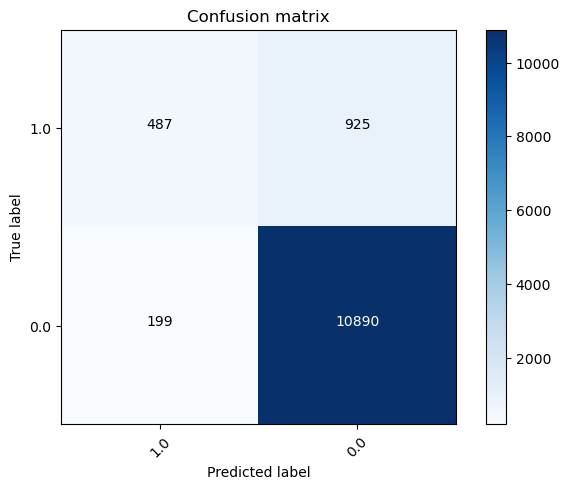

In [20]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

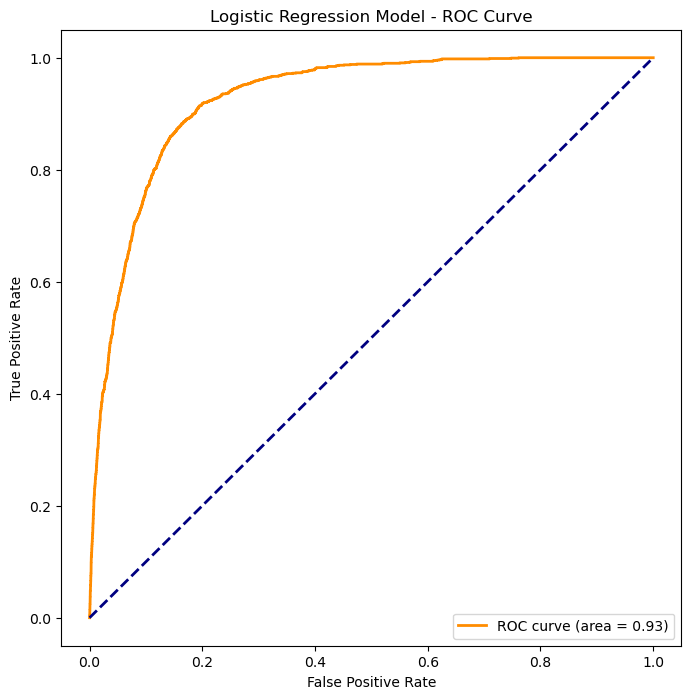

In [21]:
y_true = predictions.select('label').rdd.map(lambda x: x[0])
y_score = predictions.select('probability').rdd.map(lambda x: x[0][1])

fpr, tpr, thresholds = roc_curve(y_true.collect(), y_score.collect())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Model - ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
################ save and test loading of saved model ################

# cvModel.save('logistic_regression_cv_model')
# persistedModel_load = CrossValidatorModel.load('logistic_regression_cv_model')

# Random Forest Model

In [24]:
# random forest model
from pyspark.ml.classification import RandomForestClassifier

In [25]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=10, maxDepth=4, maxBins=32)

# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 32, 40])
             .addGrid(rf.numTrees, [10, 30])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))
print('Best Model Test F1 Score', evaluator2.evaluate(predictions))

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

Best Model Test Area Under ROC 0.9271816850376444
Best Model Test F1 Score 0.398569238630557


Confusion matrix, without normalization
[[  390  1022]
 [  155 10934]]


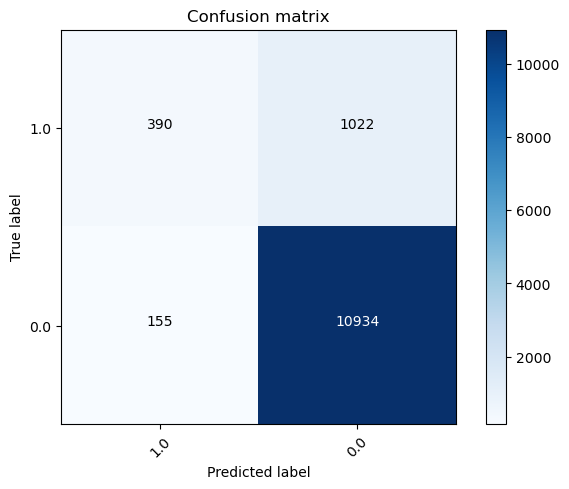

In [26]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

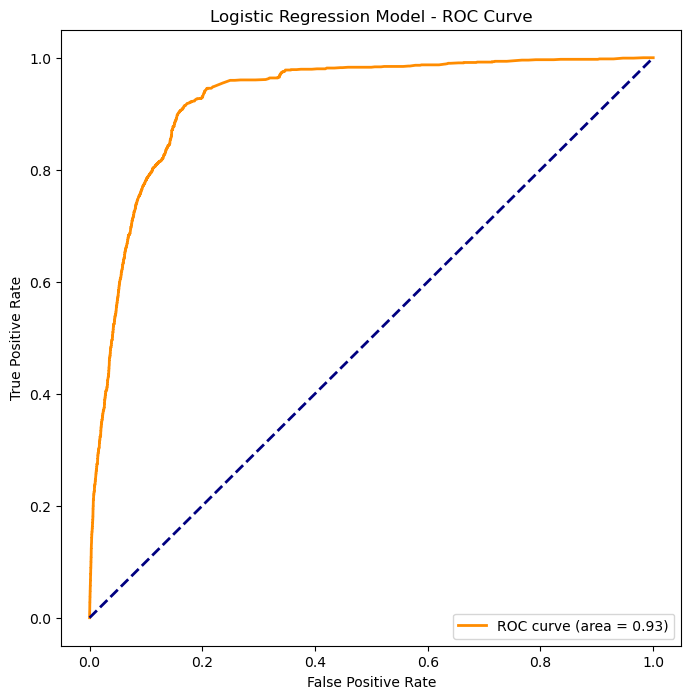

In [27]:
y_true = predictions.select('label').rdd.map(lambda x: x[0])
y_score = predictions.select('probability').rdd.map(lambda x: x[0][1])

fpr, tpr, thresholds = roc_curve(y_true.collect(), y_score.collect())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Model - ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
################ save and test loading of saved model ################

# cvModel.save('rf_cv_model')
# persistedModel_load = CrossValidatorModel.load('rf_cv_model')

# Support Vector Classifier

In [29]:
# support vector machine
from pyspark.ml.classification import LinearSVC

In [30]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, featuresCol = 'features', labelCol = 'label')

# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(lsvc.regParam, [0.1, 0.01])
             .addGrid(lsvc.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=lsvc, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Best Model Test Area Under PR Curve (No probability preds to calculate AUC for SVC Model)', evaluator.evaluate(predictions))
print('Best Model Test F1 Score', evaluator2.evaluate(predictions))

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

Best Model Test Area Under PR Curve (No probability preds to calculate AUC for SVC Model) 0.9231767783044076
Best Model Test F1 Score 0.43217054263565896


Confusion matrix, without normalization
[[  446   966]
 [  206 10883]]


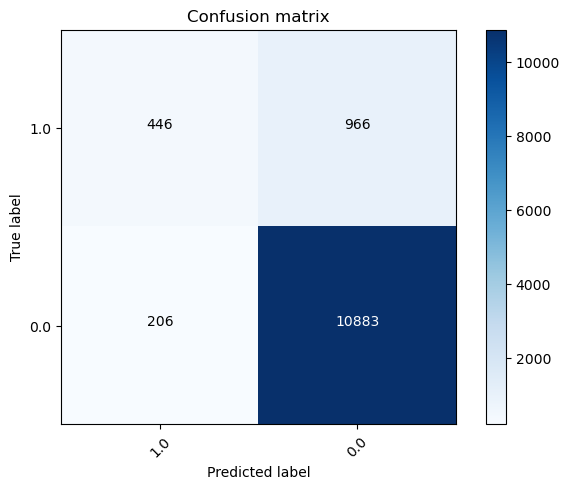

In [31]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix')
plt.show()

In [32]:
################ save and test loading of saved model ################

# cvModel.save('svc_cv_model')
# persistedModel_load = CrossValidatorModel.load('svc_cv_model')

# Gradient Boosting Classsifier

In [33]:
# gradient boosting model
from pyspark.ml.classification import GBTClassifier

In [34]:
gbt = GBTClassifier(maxIter=10, featuresCol = 'features', labelCol = 'label')

# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 32, 40])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.9420701090353941


In [35]:
print('Best Model Test F1 Score', evaluator2.evaluate(predictions))

Best Model Test F1 Score 0.5942196531791908


Confusion matrix, without normalization
[[  771   641]
 [  412 10677]]


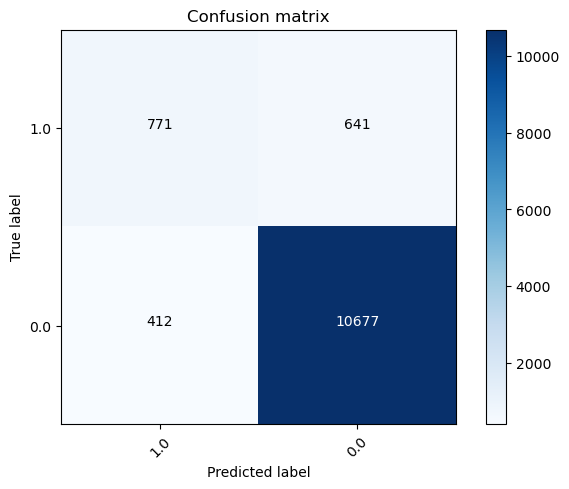

In [36]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

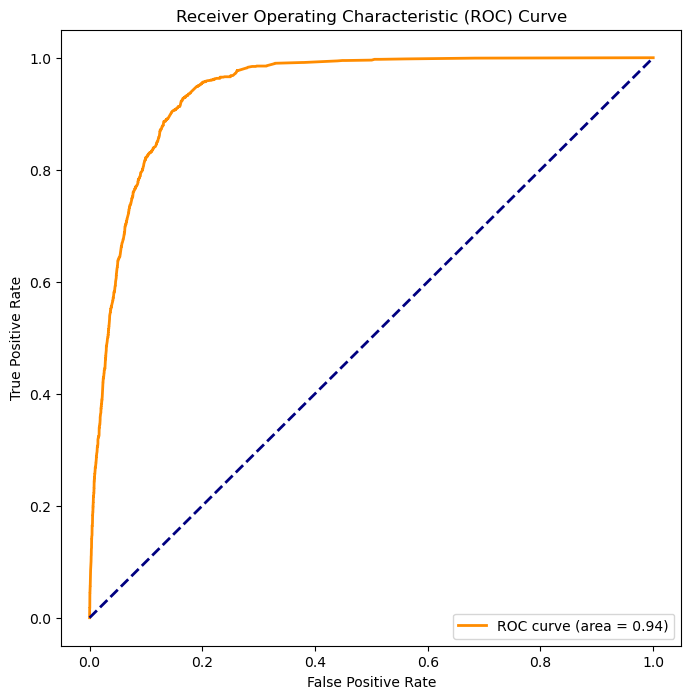

In [37]:
y_true = predictions.select('label').rdd.map(lambda x: x[0])
y_score = predictions.select('probability').rdd.map(lambda x: x[0][1])

fpr, tpr, thresholds = roc_curve(y_true.collect(), y_score.collect())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
################ save and test loading of saved model ################

# cvModel.save('gbt_cv_model')
# persistedModel_load = CrossValidatorModel.load('gbt_cv_model')

In [40]:
################ transforming the test data ################

predictions_after_loading = cvModel.bestModel.transform(test)

print('Best Model Test Area Under ROC', evaluator.evaluate(predictions_after_loading))

Best Model Test Area Under ROC 0.9420701090353941


In [41]:
#### get params of best model
print("Max Depth:", cvModel.bestModel.getMaxDepth())
print("Max Bins:", cvModel.bestModel.getMaxBins())

Max Depth: 4
Max Bins: 32


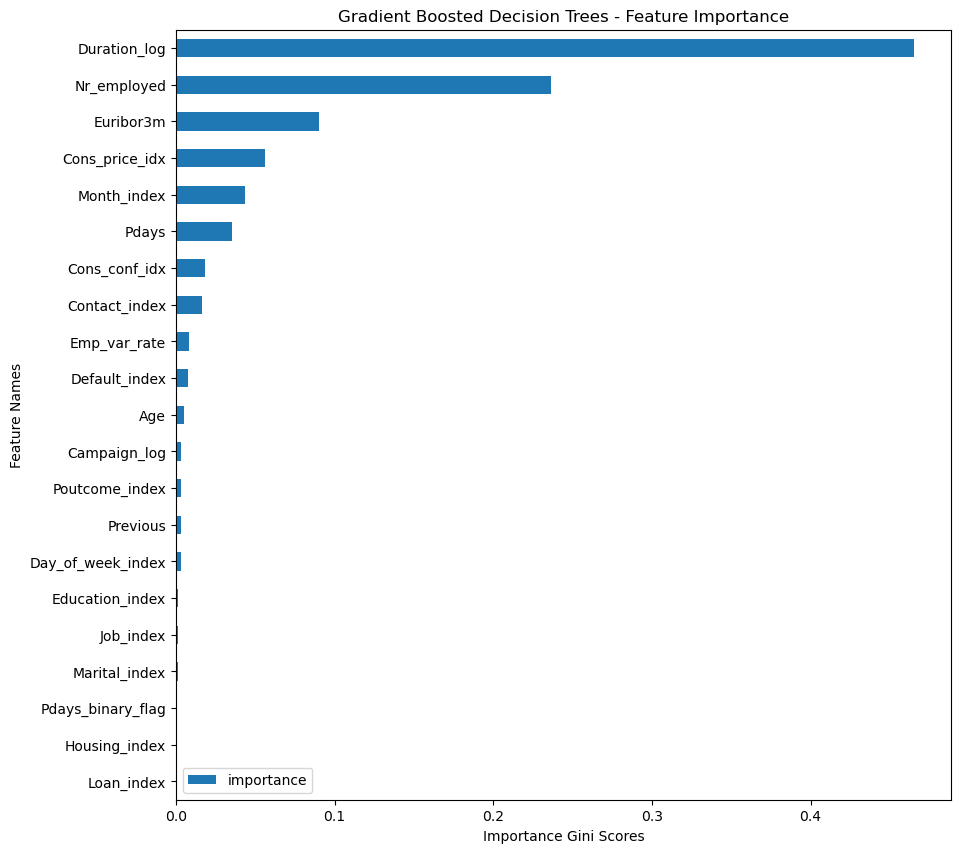

In [42]:
####################### feature importance plot for GBT model #######################

gbt2 = GBTClassifier(maxIter=10, maxDepth=4, maxBins=32, featuresCol='features_not_encoded', labelCol='label').setSeed(12345)

gbt2Model = gbt2.fit(train2)

importance_df = pd.DataFrame({
    "featureCols": inputColsNotEncoded,
    "importance": gbt2Model.featureImportances.toArray()    
})
importance_df.sort_values(by='importance', ascending=True).plot(kind='barh', x='featureCols', y='importance', figsize=(10, 10))
plt.xlabel('Importance Gini Scores')
plt.ylabel('Feature Names')
plt.title("Gradient Boosted Decision Trees - Feature Importance")
plt.show()

# Vanilla Decison Tree

In [43]:
# decision tree model
from pyspark.ml.classification import DecisionTreeClassifier

In [44]:
try:
    del predictions
except:
    pass

In [45]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 15, 20])
             .addGrid(dt.maxBins, [5, 50, 100])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)

predictions = cvModel.transform(test)

print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))
print('Best Model Test F1 Score', evaluator2.evaluate(predictions))

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

Best Model Test Area Under ROC 0.8151226926002005
Best Model Test F1 Score 0.47818499127399655


Confusion matrix, without normalization
[[  548   864]
 [  332 10757]]


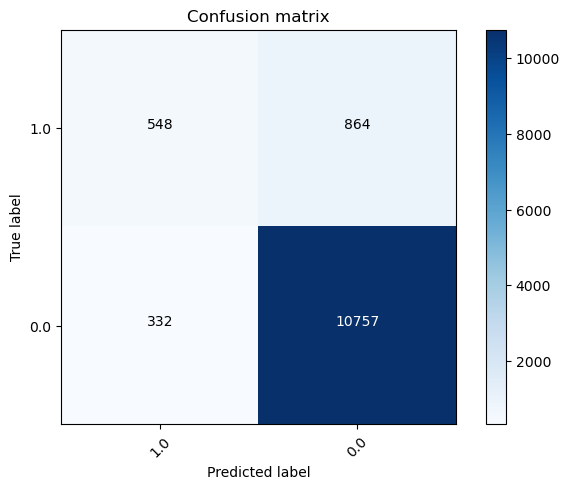

In [46]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()


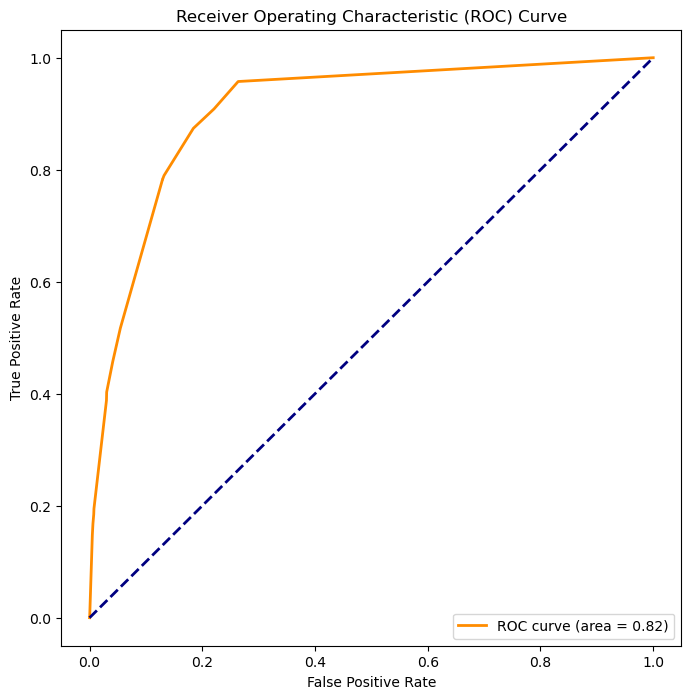

In [47]:
y_true = predictions.select('label').rdd.map(lambda x: x[0])
y_score = predictions.select('probability').rdd.map(lambda x: x[0][1])

fpr, tpr, thresholds = roc_curve(y_true.collect(), y_score.collect())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(evaluator.evaluate(predictions)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
################ save and test loading of saved model ################

# cvModel.save('vanilla_dt_cv_model')
# persistedModel_load = CrossValidatorModel.load('vanilla_dt_cv_model')

# Segmentation through K Means Clustering for use in prescriptive recommendations 

In [49]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

### Selecting only continuous numeric columns

In [50]:
continuous_feature_columns = ['Age', 'Duration', 'Campaign', 'Pdays', 'Cons_price_idx']

vec_assembler = VectorAssembler(inputCols=continuous_feature_columns, outputCol='features_kmeans')
df5 = vec_assembler.transform(df3)


### Silhoutte score for best number of clusters

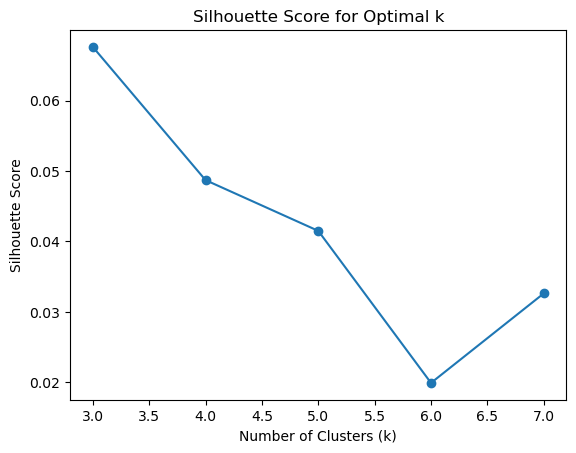

In [51]:
silhouette_scores = []
for k in [3,4,5,6,7]:
    kmeans = KMeans(featuresCol = 'features_kmeans').setK(k).setSeed(1)
    model = kmeans.fit(df5)
    predictions = model.transform(df5)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

# Plot the Silhouette Score
plt.plot([3,4,5,6,7], silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

### Rerun with best value of k

In [52]:
# Specify the number of clusters (k)
k = 6
 
# Create a KMeans model
kmeans = KMeans(featuresCol = 'features_kmeans').setK(k).setSeed(1)
 
# Fit the model to the data
kmeans_model = kmeans.fit(df5)
 
# Make predictions
predictions_kmeans = kmeans_model.transform(df5)
 
# Show the clustering results
print("Cluster Centers: ")
centers = kmeans_model.clusterCenters()
for center in centers:
    print(center)
 
# Show the assigned cluster for each data point
predictions_kmeans.select('features_kmeans', 'prediction').show()

Cluster Centers: 
[ 39.94621578 119.99090177   2.74847021 999.          93.58560511]
[ 39.98660547 341.86680405   2.28746722 999.          93.57698745]
[ 41.73033708 725.5505618    1.8164794    6.6329588   93.40567416]
[ 39.96873191 724.16299942   2.45280834 999.          93.59424986]
[ 41.87951807 229.63052209   1.82329317   5.87951807  93.32868273]
[  39.68271955 1454.71388102    2.59773371  994.78470255   93.61480312]
+--------------------+----------+
|     features_kmeans|prediction|
+--------------------+----------+
|[56.0,261.0,1.0,9...|         1|
|[57.0,149.0,1.0,9...|         0|
|[37.0,226.0,1.0,9...|         0|
|[40.0,151.0,1.0,9...|         0|
|[56.0,307.0,1.0,9...|         1|
|[45.0,198.0,1.0,9...|         0|
|[59.0,139.0,1.0,9...|         0|
|[41.0,217.0,1.0,9...|         0|
|[24.0,380.0,1.0,9...|         1|
|[25.0,50.0,1.0,99...|         0|
|[41.0,55.0,1.0,99...|         0|
|[25.0,222.0,1.0,9...|         0|
|[29.0,137.0,1.0,9...|         0|
|[57.0,293.0,1.0,9...|         

In [53]:
df_kmeans_final = predictions_kmeans.toPandas()

In [54]:
df_kmeans_final.head()
df_kmeans_final.to_csv('clustering_output_6clusters.csv', index=False)